In [1]:
target_player = '孫穎莎(RSH)'

XGBOOST

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier


# 載入資料
file_path = f"converted_data/{target_player}_data_converted.csv"
data = pd.read_csv(file_path)

# 定義需要進行 One-Hot 編碼的類別型特徵
categorical_columns = ['正反手', '技術', '速度', '旋轉', '長短', '變線', '階段']

# 初始化 OneHotEncoder，設置 handle_unknown='ignore' 並改為 sparse_output=False
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 對類別特徵進行 One-Hot 編碼
encoded_features = encoder.fit_transform(data[categorical_columns])

# 獲取編碼後的欄位名稱
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# 將編碼後的資料轉換為 DataFrame
encoded_data = pd.DataFrame(encoded_features, columns=encoded_columns)

# 將 One-Hot 編碼後的資料與原始資料合併，只保留需要的特徵
data_encoded = pd.concat([encoded_data, data[['得分']]], axis=1)

# 定義特徵與目標變數
features = [col for col in data_encoded.columns if col != '得分']
X = data_encoded[features]
y = data_encoded['得分']

# 切分資料為訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 43)

# 調整 XGBoost 參數
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state = 43)

# 訓練模型
model.fit(X_train, y_train)

# 預測測試集
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # 取得預測機率

print(f"目標選手: {target_player}")

# 評估模型準確度
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 顯示混淆矩陣
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 顯示分類報告（包含精確度、召回率和 F1-score）
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 計算  AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {roc_auc:.4f}')


目標選手: 孫穎莎(RSH)
Accuracy: 0.6715
Confusion Matrix:
[[49 30]
 [15 43]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        79
           1       0.59      0.74      0.66        58

    accuracy                           0.67       137
   macro avg       0.68      0.68      0.67       137
weighted avg       0.69      0.67      0.67       137

AUC: 0.7461


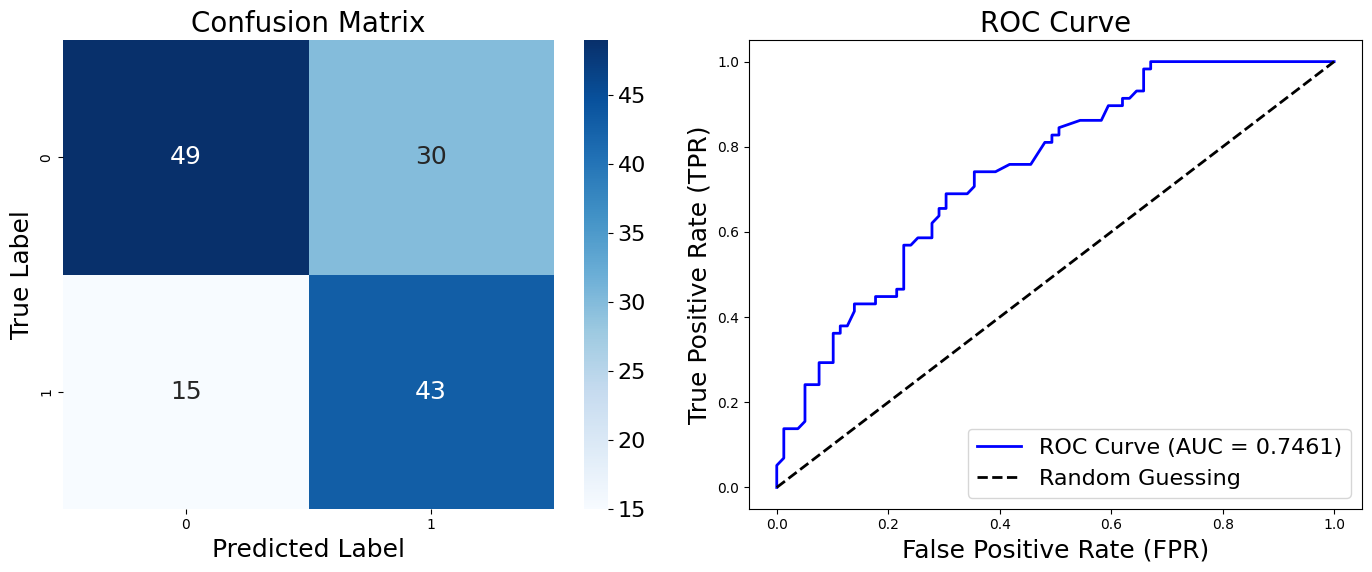

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# 創建 1 行 2 列的子圖
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 設定整體字體大小
plt.rcParams.update({'font.size': 16})

# 繪製混淆矩陣
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1], ax=axes[0], annot_kws={"size": 18})
axes[0].set_xlabel("Predicted Label", fontsize=18)
axes[0].set_ylabel("True Label", fontsize=18)
axes[0].set_title("Confusion Matrix", fontsize=20)

# 計算 ROC AUC 分數
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label="Random Guessing", linewidth=2)
axes[1].set_xlabel("False Positive Rate (FPR)", fontsize=18)
axes[1].set_ylabel("True Positive Rate (TPR)", fontsize=18)
axes[1].set_title("ROC Curve", fontsize=20)
axes[1].legend(fontsize=16)

# 調整佈局
plt.tight_layout()
plt.show()

